In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.misc import derivative
from pathlib import Path
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits import mplot3d

%matplotlib inline

In [2]:
#Make a dataframe from the sample directory. Good to visualize data. You should 
#feed this dataframe to another function that will make an array of objects

def gen_spec_df(folder_dir, meta_dic):
    
    #initialize a df of the CSV sample/scan info.
    #This should probably be something I iron out with path (it'd be a '\' on PC) but it's fine for now
    raw_df = pd.read_csv(folder_dir + "/" + meta_dic)
    
    #get the hdf filename for every file in the directory
    files = []
    for x in os.listdir(folder_dir):
        if x.endswith(".hdf5"):
            files.append(x)
    
    #Add a column for filename in meta_df that is the same length of the meta_df
    edxname = [''] * len(raw_df.index)
    raw_df['FileName'] = edxname
    
    #Find each file in the meta_df by comparing scan number. Add file name 
    for y in range(len(files)):
        hdf_file = h5py.File(directory + files[y], 'r')
        for z in range(len(raw_df.index)):
            if raw_df['ScanNum'].values[z] == hdf_file.attrs['Scan Number']:
                raw_df['FileName'].values[z] = directory+files[y]
    
    #Add a column for EDX data arrays
    edxd = [''] * len(raw_df.index)
    raw_df['Spectra'] = edxd
    raw_df['Position'] = edxd
    
    #Scan through filenames and add position and spectra data arrays to df
    #If there's none, set those values equal to some string or warning
    for h in range(len(raw_df.index)):
        datahdf = h5py.File(raw_df['FileName'].values[h], 'r')
        positionflag = 'No Position Data (uh oh)'
        spectraflag = 'No Spectra Data (uh oh)'
        with h5py.File(raw_df['FileName'].values[h], 'r') as f:
            for x in range(len(f.keys())):
                if list(f.keys())[x] == '7bmb1:aero:m2.VAL':
                    raw_df['Position'].values[h] = f['7bmb1:aero:m2.VAL'][...]
                    positionflag = 'yep'
                if list(f.keys())[x] == 'dxpMercury:mca1.VAL':
                    raw_df['Spectra'].values[h] = f['dxpMercury:mca1.VAL'][...]
                    spectraflag = 'yep'
        if positionflag != 'yep':
            raw_df['Position'].values[h] = []
        if spectraflag != 'yep':
            raw_df['Spectra'].values[h] = []

    return raw_df

In [3]:
directory = '/Users/anthonygironda/Documents/MDA_Scans_Seidler/'
meta = '7bmb1_10.19.22_EDXindex.csv'

sample_df = gen_spec_df(directory, meta)
#sample_df.head()

In [4]:
class scan:
    
    normalization = 1
    cal_feat_1 = (275, 2292.1)
    cal_feat_2 = (934, 8397.6)
    units = 'bins'
    
    def __init__(self, spectra, position_from_center):
        self.spectra = spectra
        self.beam_position = position_from_center

    def set_energy_scale(self, tuple1, tuple2):
        self.cal_feat_1 = tuple1
        self.cal_feat_2 = tuple2
        
    def set_units(self, unit):
        if unit == 'energy' or unit == 'bins' or unit == '2 theta':
            self.units = unit
        else: print('Unit must be set to "energy" , "2 theta", or "bins"')

    def get_energy_scale(self): return (self.cal_feat_1, self.cal_feat_2)

    def get_units(self): return (self.units)
         
    def quick_plot(self):
        spec_data = self.spectra
        x_dat = list(range(len(spec_data)))
        fig, ax = plt.subplots()
        ax.plot(x_dat, spec_data, linewidth=2.0)
        ax.grid(True);
        return (fig, ax)
    
    def quick_scatter(self):
        spec_data = self.spectra
        x_dat = list(range(len(spec_data)))
        fig, ax = plt.subplots()
        ax.scatter(x_dat, spec_data)
        ax.grid(True);
        return (fig, ax)
    
    def quick_scatter1(self):
        spec_data = self.spectra
        x_dat = list(range(len(spec_data)))
        x_dat_en = []
        x1 = self.cal_feat_1[0]
        y1 = self.cal_feat_1[1]
        x2 = self.cal_feat_2[0]
        y2 = self.cal_feat_2[1]
        for a in range(len(x_dat)):
            lin_interp = (y2-y1)*(a-x1)/(x2-x1) + y1
            x_dat_en.append(lin_interp)
        fig, ax = plt.subplots(figsize = (10,6))
        ax.plot(x_dat_en, spec_data)
        ax.grid(True);
        return (fig, ax)
    
    def bins_to_energy(self, x_data_array):
        x_data_en = []
        x1 = self.cal_feat_1[0]
        y1 = self.cal_feat_1[1]
        x2 = self.cal_feat_2[0]
        y2 = self.cal_feat_2[1]
        for a in range(len(x_data_array)):
            lin_interp = (y2-y1)*(x_data_array[a]-x1)/(x2-x1) + y1
            x_data_en.append(lin_interp)
        return x_data_en

    def bins_to_energy2(self):
        spec_data = self.spectra
        x_data = list(range(len(spec_data)))
        x_dat_en = []
        x1 = self.cal_feat_1[0]
        y1 = self.cal_feat_1[1]
        x2 = self.cal_feat_2[0]
        y2 = self.cal_feat_2[1]
        for a in range(len(x_data)):
            lin_interp = (y2-y1)*(a-x1)/(x2-x1) + y1
            x_dat_en.append(lin_interp)
        return x_data_en
        

In [5]:
#When bool_pos_given_as_index is True, the pos instantiation variable is an index. Otherwise, when false,
#the pos instantiation variable is an actual position value, like -13.0 or 6.75. It also catches
#an edge case when the position array is empty, such as the calibration scan 1069. Things may behave funny when
#position arrays end in duplicates of 0s or any duplicates in general

#There's potentially a problem for if the spectra passed to the scan is a list or a numpy array, be aware.
def scan_instant_helper(df, scannum, pos, bool_pos_given_as_index):
    errorflag = True
    pos_i = None
    scan_index = (df[df['ScanNum']==scannum].index.values)[0]
    pos_array = df['Position'][scan_index]
    
    #edge case checker, if the position array of a given scan number is empty
    if ((pos == 0) and len(pos_array)==0):
        spectra_set = df['Spectra'][scan_index]
        spectra = spectra_set
        return scan(spectra, None)

    #If the bool is given as true, treat the pos variable like an index and not a value
    #Check first that the pos as an index is within the range of the scan's position array
    if bool_pos_given_as_index == True:
        if pos > (len(pos_array)-1): 
            return print('ERROR: Index is out of range of position array')
        else:
            pos_i = pos
            pos_value = abs(df['Position'][scan_index][pos_i])
            spectra_set = df['Spectra'][scan_index]
            spectra = spectra_set[pos_i]
            return scan(spectra, pos_value)
    
    #Otherwise, the bool was false and the pos variable was given as an actual position in the array
    #Check first that the pos value is actually in the array, and if so instantiate the scan with appropriate info
    else:
        for a in range(len(pos_array)):
            pos_val = pos_array[a]
            #This old logic in the 'or' statement was to catch the empty edge case, it should be unnecessary now
            if abs(pos_array[a])==abs(pos) or ((pos == 0) and len(pos_array)==0): 
                errorflag = False
                pos_i = a
                
        if errorflag == True: print('ERROR: Position is out of range')
        else:
            spectra_set = df['Spectra'][scan_index]
            spectra = spectra_set[pos_i]
            position_val = abs(df['Position'][scan_index][pos_i])
            return scan(spectra, position_val)

In [6]:
scan_n = 1106

s1 = scan_instant_helper(sample_df, scan_n, 13, False)
s2 = scan_instant_helper(sample_df, scan_n, 12.75, False)
s3 = scan_instant_helper(sample_df, scan_n, 12.5, False)
s4 = scan_instant_helper(sample_df, scan_n, 12.25, False)
s5 = scan_instant_helper(sample_df, scan_n, 12, False)
s6 = scan_instant_helper(sample_df, scan_n, 11.75, False)
s7 = scan_instant_helper(sample_df, scan_n, 11.5, False)
s8 = scan_instant_helper(sample_df, scan_n, 11.25, False)
s9 = scan_instant_helper(sample_df, scan_n, 11, False)
s10 = scan_instant_helper(sample_df, scan_n, 10.75, False)
s11 = scan_instant_helper(sample_df, scan_n, 10.5, False)
s12 = scan_instant_helper(sample_df, scan_n, 10.25, False)
s13 = scan_instant_helper(sample_df, scan_n, 10, False)
s14 = scan_instant_helper(sample_df, scan_n, 9.75, False)
s15 = scan_instant_helper(sample_df, scan_n, 9.5, False)
s16 = scan_instant_helper(sample_df, scan_n, 9.25, False)
s17 = scan_instant_helper(sample_df, scan_n, 9, False)
s18 = scan_instant_helper(sample_df, scan_n, 8.75, False)
s19 = scan_instant_helper(sample_df, scan_n, 8.5, False)
s20 = scan_instant_helper(sample_df, scan_n, 8.25, False)
s21 = scan_instant_helper(sample_df, scan_n, 8, False)
s22 = scan_instant_helper(sample_df, scan_n, 7.75, False)
s23 = scan_instant_helper(sample_df, scan_n, 7.5, False)
s24 = scan_instant_helper(sample_df, scan_n, 7.25, False)
s25 = scan_instant_helper(sample_df, scan_n, 7, False)
s26 = scan_instant_helper(sample_df, scan_n, 6.75, False)
s27 = scan_instant_helper(sample_df, scan_n, 6.5, False)
s28 = scan_instant_helper(sample_df, scan_n, 6.25, False)
s29 = scan_instant_helper(sample_df, scan_n, 6, False)

slist = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28,s29]


In [171]:
class sample:
    
    recipe_ph = None
    recipe_steel = None
    
    aging_temp = None
    aging_atm = None
    aging_humidity = None
    aging_time = None
    
    def __init__(self, sample_name, scan_set):
        self.name = sample_name
        self.scans = scan_set
        self.scan_len = len(self.scans)
            
    #Set attributes of the class, the instantiation helper function should do most of this
    def set_ph(self, hi_low_string): self.recipe_ph = hi_low_string
    def set_steel_fiber(self, true_false): self.recipe_steel = true_false
    def set_temp(self, temperature): self.aging_temp = temperature
    def set_atm(self, atmosphere): self.aging_atm = atmosphere
    def set_humidity(self, rh): self.aging_humidity = rh
    def set_time(self, days): self.aging_time = days

    #Return values of each attribute or parameter
    def get_ph(self): return (self.recipe_ph)
    def get_steel_fiber(self): return (self.recipe_steel)    
    def get_temp(self): return (self.aging_temp)    
    def get_atm(self): return (self.aging_atm)
    def get_humidity(self): return (self.aging_humidity)
    def get_time(self): return (self.aging_time)
    def get_len(self): return self.scan_len 
    def get_positions(self):
        scan_pos = []
        for a in range(self.scan_len):
            if (self.scans[a]).beam_position == None:
                scan_pos.append(0)
            else:
                scan_pos.append((self.scans[a]).beam_position)
        return scan_pos
      
        
        
    #Quick plotting functions of the class:
    def quick_plot(self):
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        fig, ax = plt.subplots()#(figsize=(5, 2.7), layout='constrained')
        for g in range(length):
            ax.plot(x_data_bins, (self.scans[g]).spectra, linewidth=0.5)
        ax.grid(True)
        return (fig, ax)
    
    def quick_stack(self):
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        fig, ax = plt.subplots()#(figsize=(5, 2.7), layout='constrained')
        for g in range(length):
            ax.plot(x_data_bins, (self.scans[g]).spectra + g*50, linewidth=0.5)
        ax.grid(True)
        return (fig, ax)
    
    def quick_integral(self, limits, index_start):
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        integrate_peak = []
        position_array = []#self.get_positions()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        peak_max = 0.0
        for g in range(length):
            if g >= index_start:
                position_array.append((self.scans[g]).beam_position)
                ax1.plot(x_data_bins, (self.scans[g]).spectra, linewidth=.8, color = 'b')
                intensity = (self.scans[g]).spectra
                peak_area = 0.0
                for h in range(limits[0], limits[1]):
                    i1 = intensity[h]
                    i2 = intensity[h+1]
                    avg = (i1 + i2)/2
                    peak_area = peak_area + avg
                    if ((self.scans[g]).spectra)[h] > peak_max:
                        peak_max = ((self.scans[g]).spectra)[h]            
                integrate_peak.append(peak_area)
        ax1.set_xlim(limits[0],limits[1])
        ax1.set_ylim(0, peak_max + 50)
        ax2.plot(position_array, integrate_peak, linewidth=1)
        ax1.grid(True)
        ax2.grid(True)
        ax1.set_xlabel('Bin Number')
        ax2.set_xlabel('Radius [mm]')
        ax1.set_ylabel('Counts')
        ax2.set_ylabel('Peak Area')
        fig.suptitle(str(self.name) + " Sample's Peak and Peak Area Integral as a Function of Radius")
        fig.tight_layout()
        return (fig, (ax1, ax2))
    
    def quick_wire(self):
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        pos_array = self.get_positions()
        dataset = []
        for r in range(length):
            tup = self.scans[r].spectra, pos_array[r]
            dataset.append(tup)
        return dataset
    
    
    
    def stack(self, off):
        y_off = off
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        fig, ax = plt.subplots()#(figsize=(5, 2.7), layout='constrained')
        for g in range(length):
            ax.plot(x_data_bins, (self.scans[g]).spectra + g*y_off, linewidth=0.5)
        ax.grid(True)
        return (fig, ax)

    
    
    #Custom Plotting methods of the class:
    def custom_stack(self, **kwargs):
        i_bound = (None, None)
        intervals = None
        y_off = 0
        x_bound = (None, None)
        y_bound = (None, None)
        units = 'Bins'
        
        for key, value in kwargs.items():
            
            #Setting the bounds of the stacked data
            if key == 'i':
                i = value
                #if i is given as a tuple:
                if type(i) == tuple:
                    if type(i[0]) == int and type(i[1]) == int:
                        if i[0] < 0 or i[1] < 0:
                            return print('Error: Int cannot be negatives')
                        elif i[0] > len(self.get_positions()) or i[1] > len(self.get_positions()):
                            return print('Error: Index out of range')
                        else:
                            if i[0] == i[1]: i_bound = (i[0], i[0])
                            if i[1] > i[0]: i_bound = (i[0], i[1])
                            else: i_bound = (i[1], i[0])
                    else: return print('Error: Expected tuple of two ints')

                #If i is given as an int:    
                elif type(i) == int:
                    if i < 1: return print('Error: i must be an int greater than 0')
                    elif i < len(self.get_positions()): i_bound = (i, None)
                    else: return print('Error: i is out of range')

                #if i is given as wrong type:
                else:
                    return print('Error: Expected i bound(s) as int or int tuple')
            
            #Interval of plotting (i.e. skip every other if interval == 2, etc.)
            elif key == 'interval':
                interval = value
                if type(interval) == int:
                    if interval > 0:
                        if interval < len(self.get_positions()): intervals = interval
                        else: return print('Error: Interval out of bounds')
                    else: return print('Error: Expected interval greater than 0')
                else: return print('Error: Expected interval as int')
            
            #Spacing between lines
            elif key == 'spacing':
                offset = value
                if type(offset) != int or offset < 1: return print('Error: Expected spacing as int greater than 0')
                else:
                    y_off = value
            
            #Xlimits of the graph
            elif key == 'xlim':
                x_range = value
                if type(x_range) == int: x_bound = (x_range, None)
                elif type(x_range) == tuple: x_bound = x_range
                else: return print('Error: Expected xlim as int or int tuple')

            #Ylimits of the graph
            elif key == 'ylim':
                y_range = value
                if type(y_range) == int: y_bound = (y_range, None)
                elif type(y_range) == tuple: y_bound = y_range
                else: return print('Error: Expected ylim as int or int tuple')            
            

        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        fig, ax = plt.subplots()#(figsize=(5, 2.7), layout='constrained')
        for g in range(length):
            ax.plot(x_data_bins, (self.scans[g]).spectra + g*y_off, linewidth=0.5)
        ax.grid(True)
        return (fig, ax)
        
        
    def plot(self):
        return
    def stackplot(self):
        return
    def plot_d(self):
        return
    def stackplot_d(self):
        return
    
hpbl2514 = sample('High pH BL 25C 14d', slist)
hpbl2514.set_ph('High')
hpbl2514.set_steel_fiber(False)
hpbl2514.set_temp(25)
hpbl2514.set_atm('100% CO2')
hpbl2514.set_time(14)

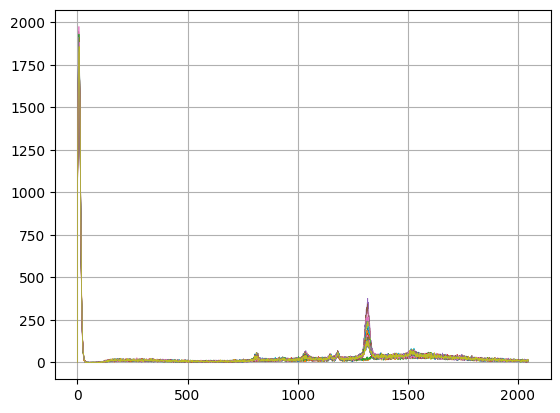

In [172]:
s1 = hpbl2514.custom_stack(i = (28, 5), interval = 10, xlim = (10.5, 7.20))

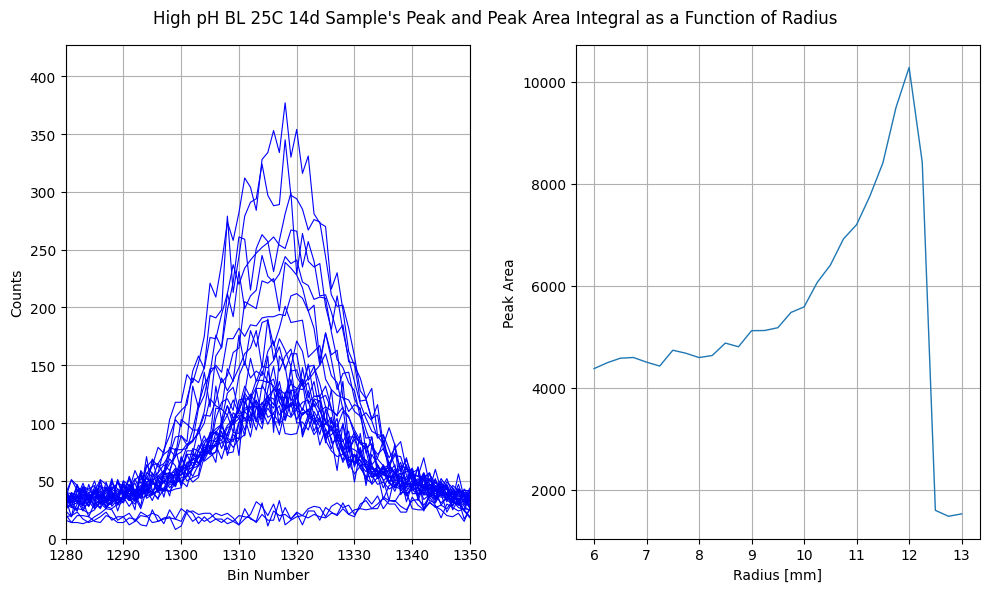

In [190]:
# stackp = hpbl2514.stack(120)
# stackp[1].set_xlim(1275, 1350)
# stackp[1].set_ylim(0, 4000)

b = hpbl2514.quick_integral((1280, 1350), 0)

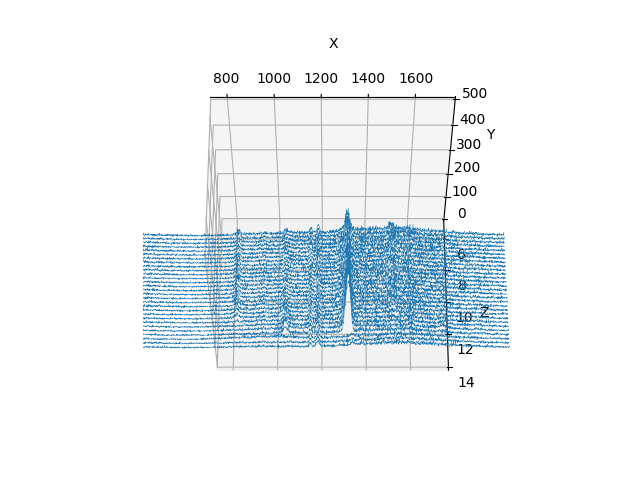

In [30]:
hell = hpbl2514.quick_wire()
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection= '3d')

# def plot2din3d(x,y,z):
#     ax.plot(x, y, zs=z, zdir='z')
#     a2d_col_obj = ax.fill_between(x, 0.5, y, step='pre', alpha=0.1) 
#     ax.add_collection3d(a2d_col_obj, zs = z, zdir = 'z')
    
# Plot a sin curve using the x and y axes.
for z in range(len(hell)):
    x = list(range(len(hell[z][0])))
    y = hell[z][0]
    zed = hell[z][1]
    ax.plot(x, y, zed, linewidth = 0.3, color = 'tab:blue')
    
#ax.legend()
ax.set_xlim(750, 1750)
ax.set_ylim(0, 500)
ax.set_zlim(5, 14)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(150, -90)

plt.show()



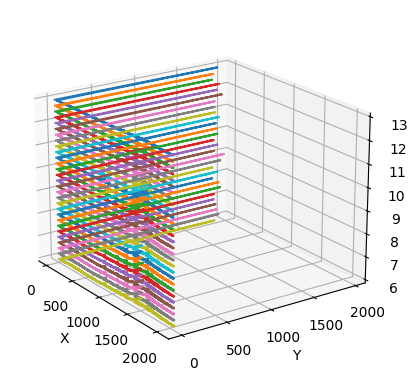

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection= '3d')

def plot2din3d(x,y,z):
    ax.plot(x, y, zs=z, zdir='z')
    a2d_col_obj = ax.fill_between(x, 0.5, y, step='pre', alpha=0.1) 
    ax.add_collection3d(a2d_col_obj, zs = z, zdir = 'z')
    
# Plot a sin curve using the x and y axes.
for z in range(len(hell)):
    x = list(range(len(hell[z][0])))
    y = hell[z][0]
    plot2din3d(x, y, hell[z][1])
    
#ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=20., azim=-35)

plt.show()



(0.0, 500.0)

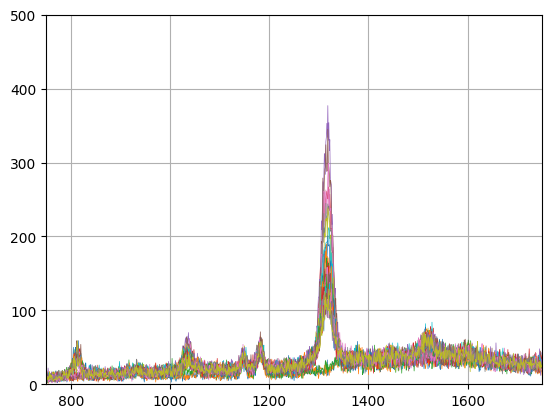

In [13]:
qp = hpbl2514.quick_plot()
qp[1].set_xlim(750, 1750)
qp[1].set_ylim(0, 500)

tuple

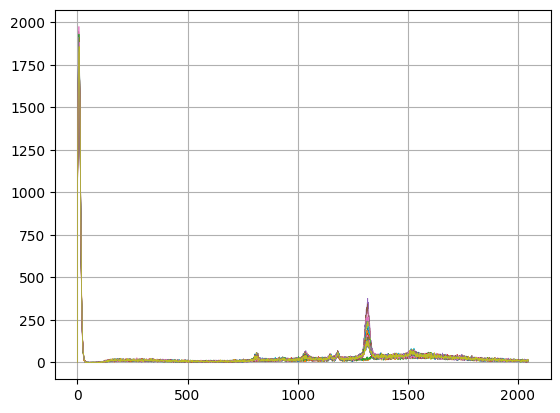

In [14]:
x = hpbl2514.quick_plot()
type(x)

In [15]:
Mo_W = scan_instant_helper(sample_df, 1069, 0, False)
calcite = scan_instant_helper(sample_df, 1071, 0, True)

t = sample('Please work you stupid bastard', [Mo_W, calcite])

print(t.name)


Please work you stupid bastard


In [16]:
def sample_instant_helper(df, scannum):
    errorflag = True
    scan_obj_list = []

In [17]:
class series:
    def __init__(self, sample_list):
        return

In [18]:
Mo_W_cal = scan_instant_helper(sample_df, 1069, 0, False)
calcite_ref = scan_instant_helper(sample_df, 1071, 0, True)

Mo_W_cal.spectra

# Mo_W_cal.quick_plot()
# Mo_W_cal.quick_scatter1()

array([   0., 5366., 6316., ...,   16.,   16.,   14.])

In [19]:
def sample_instant_helper(df, scannum, name):
    errorflag = True
    scan_obj_list = []
    scan_index = (df[df['ScanNum']==scannum].index.values)
    scan_pos_arr = df['Position'][scan_index]
    
    #Edge check, if pos array is empty
    if len(scan_pos_arr)==0:
        spectra_set = df['Spectra'][scan_index]
        spectra = spectra_set
        scan_obj_list.append(scan(spectra, None))
    
    #Otherwise make a scan object at each position and add scan object to a list
    else:
        for a in range(len(scan_pos_arr)):
            spectra_set = df['Spectra'][scan_index]
            spectra = spectra_set[a]
            pos = scan_pos_arr[a]
            scan_obj_list.append(scan(spectra, pos))
    
    #make the sample object with the proper list of scans
    sample_obj = sample(str(name), scan_obj_list)
    
    #set attributes of the sample object from values in the data frame
    # pH = df['pH'][scan_index].values
    # steel = df['SteelFiber'][scan_index].item()
    # temp = df['Temperature'][scan_index].item()
    # atm = df['Atmosphere'][scan_index].item()
    # #humidity = df['Humidity'][scan_index].item()
    # days = df['Days'][scan_index].item()
    
#     if pH[0] == 1:
#         pH = 'High'
#     elif pH[0] == 0:
#         pH = 'Low'
#     else:
#         pH = None
        
    # if steel == True:
    #         steel = True
    # elif steel == 0:
    #      steel == False

        
    # sample_obj.set_ph(pH)
    # # sample_obj.set_steel_fiber(steel)
    # # sample_obj.set_temp(temp)
    # # sample_obj.set_atm(str(atm))
    # # #sample_obj.set_humidity(rh)
    # # sample_obj.set_time(str((days)) + ' Days')
    
    return scan_obj_list



In [20]:
def sample_instant_helper(df, scannum, name):
    errorflag = True
    scan_obj_list = []
    scan_index = (df[df['ScanNum']==scannum].index.values)
    scan_pos_arr = df['Position'][scan_index]
    
#     #Edge check, if pos array is empty
#     if len(scan_pos_arr)==0:
#         spectra_set = df['Spectra'][scan_index]
#         spectra = spectra_set
#         scan_obj_list.append(scan(spectra, None))
    
#     #Otherwise make a scan object at each position and add scan object to a list
#     else:
    for a in range(len(scan_pos_arr)):
        spectra_set = df['Spectra'][scan_index]
        spectra = spectra_set[a]
        pos = scan_pos_arr[a]
        scan_obj_list.append(scan(spectra, pos))
    
    #make the sample object with the proper list of scans
    sample_obj = sample(str(name), scan_obj_list)
    
    #set attributes of the sample object from values in the data frame
    # pH = df['pH'][scan_index].values
    # steel = df['SteelFiber'][scan_index].item()
    # temp = df['Temperature'][scan_index].item()
    # atm = df['Atmosphere'][scan_index].item()
    # #humidity = df['Humidity'][scan_index].item()
    # days = df['Days'][scan_index].item()
    
#     if pH[0] == 1:
#         pH = 'High'
#     elif pH[0] == 0:
#         pH = 'Low'
#     else:
#         pH = None
        
    # if steel == True:
    #         steel = True
    # elif steel == 0:
    #      steel == False

        
    # sample_obj.set_ph(pH)
    # # sample_obj.set_steel_fiber(steel)
    # # sample_obj.set_temp(temp)
    # # sample_obj.set_atm(str(atm))
    # # #sample_obj.set_humidity(rh)
    # # sample_obj.set_time(str((days)) + ' Days')
    
    return scan_obj_list



In [21]:
scan_n = 1106

s1 = scan_instant_helper(sample_df, scan_n, 13, False)
s2 = scan_instant_helper(sample_df, scan_n, 12.75, False)
s3 = scan_instant_helper(sample_df, scan_n, 12.5, False)
s4 = scan_instant_helper(sample_df, scan_n, 12.25, False)
s5 = scan_instant_helper(sample_df, scan_n, 12, False)
s6 = scan_instant_helper(sample_df, scan_n, 11.75, False)
s7 = scan_instant_helper(sample_df, scan_n, 11.5, False)
s8 = scan_instant_helper(sample_df, scan_n, 11.25, False)
s9 = scan_instant_helper(sample_df, scan_n, 11, False)
s10 = scan_instant_helper(sample_df, scan_n, 10.75, False)
s11 = scan_instant_helper(sample_df, scan_n, 10.5, False)
s12 = scan_instant_helper(sample_df, scan_n, 10.25, False)
s13 = scan_instant_helper(sample_df, scan_n, 10, False)
s14 = scan_instant_helper(sample_df, scan_n, 9.75, False)
s15 = scan_instant_helper(sample_df, scan_n, 9.5, False)
s16 = scan_instant_helper(sample_df, scan_n, 9.25, False)
s17 = scan_instant_helper(sample_df, scan_n, 9, False)
s18 = scan_instant_helper(sample_df, scan_n, 8.75, False)
s19 = scan_instant_helper(sample_df, scan_n, 8.5, False)
s20 = scan_instant_helper(sample_df, scan_n, 8.25, False)
s21 = scan_instant_helper(sample_df, scan_n, 8, False)
s22 = scan_instant_helper(sample_df, scan_n, 7.75, False)
s23 = scan_instant_helper(sample_df, scan_n, 7.5, False)
s24 = scan_instant_helper(sample_df, scan_n, 7.25, False)
s25 = scan_instant_helper(sample_df, scan_n, 7, False)
s26 = scan_instant_helper(sample_df, scan_n, 6.75, False)
s27 = scan_instant_helper(sample_df, scan_n, 6.5, False)
s28 = scan_instant_helper(sample_df, scan_n, 6.25, False)
s29 = scan_instant_helper(sample_df, scan_n, 6, False)

slist = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28,s29]

hpbl2514 = sample('High pH BL 25C 14d', slist)
hpbl2514.set_ph('High')
hpbl2514.set_steel_fiber(False)
hpbl2514.set_temp(25)
hpbl2514.set_atm('100% CO2')
hpbl2514.set_time(14)

print(hpbl2514.get_ph())
print(hpbl2514.get_steel_fiber())
print(hpbl2514.get_temp())
print(hpbl2514.get_atm())
print(hpbl2514.get_time())

print('\n')

print(type(hpbl2514.get_ph()))
print(type(hpbl2514.get_steel_fiber()))
print(type(hpbl2514.get_temp()))
print(type(hpbl2514.get_atm()))
print(type(hpbl2514.get_time()))

print('\n')

print(hpbl2514.get_positions())
print(hpbl2514.get_len())

High
False
25
100% CO2
14


<class 'str'>
<class 'bool'>
<class 'int'>
<class 'str'>
<class 'int'>


[13.0, 12.75, 12.5, 12.25, 12.0, 11.75, 11.5, 11.25, 11.0, 10.75, 10.5, 10.25, 10.0, 9.75, 9.5, 9.25, 9.0, 8.75, 8.5, 8.25, 8.0, 7.75, 7.5, 7.25, 7.0, 6.75, 6.5, 6.25, 6.0]
29
